# Quantum Support Vector Machine (QSVM)

Reference:
1. https://qiita.com/ttabata/items/e5d18f10149a3cd81f80
2. https://www.kikagaku.co.jp/kikagaku-blog/pytorch-torchvision/#i-4
3. https://qiita.com/shinji_komine/items/460ca7a953131d749203
4. https://qiita.com/makaishi2/items/2d0dd015ac1cbd86dd3f
5. https://qiita.com/tetsuro731/items/d64b9bbb8de6874b7064


In [ ]:
import copy
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from sklearn import metrics
from sklearn.decomposition import PCA
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZZFeatureMap
from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit_machine_learning.optimizers import SPSA
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel, TrainableFidelityQuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.algorithms import QSVC
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from compose_mnist_dataset import ComposeMnistDataset


In [4]:
class QKTCallback:
    def __init__(self) -> None:
        self._data = [[] for i in range(5)]

    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

    def get_callback_data(self):
        return self._data

    def clear_callback_data(self):
        self._data = [[] for i in range(5)]

In [5]:
class QSVCVisualization:
    def __init__(self, cmd: ComposeMnistDataset):
        self.cmd = cmd

    def display_kernel_loss_and_matrix(self, plot_data, K):
        plt.rcParams["font.size"] = 14
        fig, ax = plt.subplots(1, 2, figsize=(14, 5))
        ax[0].plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), c="k", marker="o")
        ax[0].set_xlabel("Iterations")
        ax[0].set_ylabel("Loss")
        ax[1].imshow(K, cmap=matplotlib.colormaps["bwr"])
        fig.tight_layout()
        plt.show()

    # TODO: the function doesn't work well.
    def display_dicision_border(self, X, y, qsvc):
        plt = self.cmd.plot_pca_features()

        inverse_transform = lambda x, std=0.5, mean=0.5: x * std + mean

        h = 0.1

        x_min, x_max = X[:, 0].min(), X[:, 0].max()
        y_min, y_max = X[:, 1].min(), X[:, 1].max()

        xx, yy = np.meshgrid(
            np.linspace(x_min, x_max, int((x_max - x_min) / h)),
            np.linspace(y_min, y_max, int((y_max - y_min) / h))
        )

        if self.cmd.num_comp != 0:
            xx_inv = inverse_transform(xx)
            yy_inv = inverse_transform(yy)

            X_inv = inverse_transform(X)

        grid_points = np.c_[xx.ravel(), yy.ravel()]

        # Z = qsvc.predict_proba(grid_points)[:, 1]
        # Z = Z.reshape(xx.shape)

        plt.scatter(X_inv[:, 0], X_inv[:, 1], c=y, cmap='coolwarm', edgecolors='k')
        # plt.contourf(xx, yy, Z, alpha=0.5)
        # plt.contour(xx, yy, Z, levels=[0.5], colors='k', linestyles='solid', linewidth=2)

        plt.title("SVM Decision Boundary")

        plt.show()


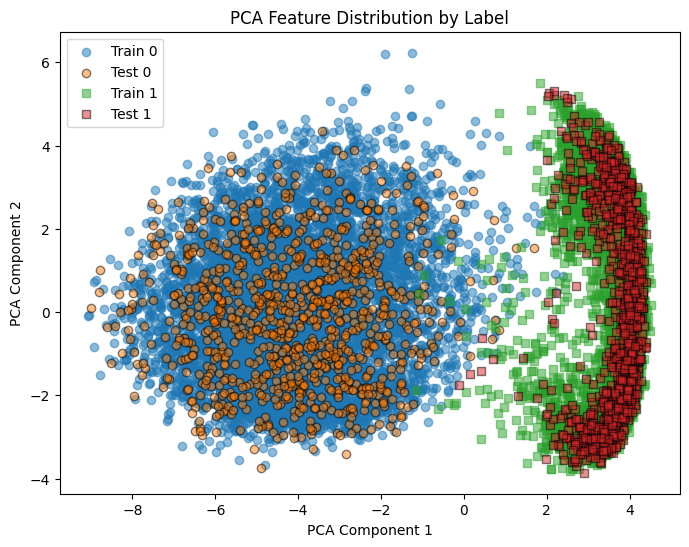

==== dataset infomation ====
# of train datasets: 12665
# of test datasets: 2115
shape of data: torch.Size([2])
data type: torch.float32
class distribution(train data): 
    class 0: 5923
    class 1: 6742
class distribution(test data): 
    class 0: 980
    class 1: 1135


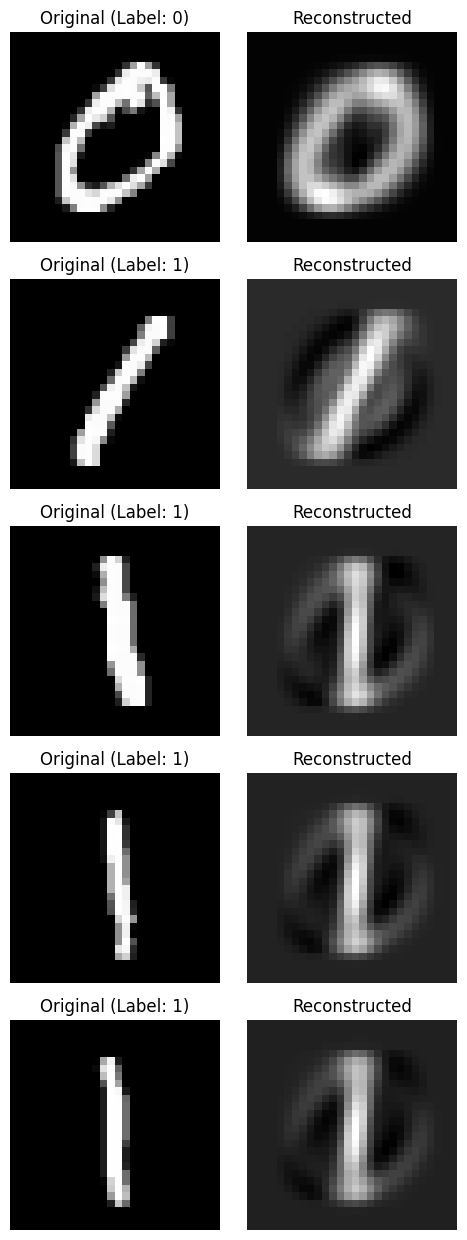

In [6]:
dataset = ComposeMnistDataset(None, None, 32, 32, 2, True)
train_loader, test_loader = dataset.exec(filter=[0, 1], size=None)


In [7]:
training_params = ParameterVector("Θ", 1)
fm0 = QuantumCircuit(2)
fm0.ry(training_params[0], 0)
fm0.ry(training_params[0], 1)

fm1 = ZZFeatureMap(2)

fm = fm0.compose(fm1)

fm.draw('mpl')
print(f"Trainable parameters: {training_params}")


Trainable parameters: Θ, ['Θ[0]']


In [8]:
backend = AerSimulator()
sampler = Sampler()

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_fm = pm.run(fm)

fidelity = ComputeUncompute(sampler=sampler)

quant_kernel = TrainableFidelityQuantumKernel(
    fidelity=fidelity, feature_map=isa_fm, training_parameters=training_params
)

cb_qkt = QKTCallback()
spsa_opt = SPSA(maxiter=10, callback=cb_qkt.callback, learning_rate=0.05, perturbation=0.05)

qkt = QuantumKernelTrainer(
    quantum_kernel=quant_kernel, loss="svc_loss", optimizer=spsa_opt, initial_point=[np.pi/2]
)

In [9]:
img_batch, label_batch = next(iter(train_loader))
img_batch2, label_batch2 = next(iter(test_loader))

img_batch = img_batch.view(img_batch.shape[0], -1)
img_batch2 = img_batch2.view(img_batch2.shape[0], -1)

qka_results = qkt.fit(img_batch, label_batch)
optimized_kernel = qka_results.quantum_kernel
print(qka_results)

{   'optimal_circuit': None,
    'optimal_parameters': {   ParameterVectorElement(Θ[0]): np.float64(2.560655896352868)},
    'optimal_point': array([2.5606559]),
    'optimal_value': np.float64(23.643632846630336),
    'optimizer_evals': 30,
    'optimizer_result': None,
    'optimizer_time': None,
    'quantum_kernel': <qiskit_machine_learning.kernels.trainable_fidelity_quantum_kernel.TrainableFidelityQuantumKernel object at 0x7f70236c19c0>}


In [10]:
qsvc = QSVC(quantum_kernel=optimized_kernel, probability=True)
qsvc.fit(img_batch, label_batch)

labels_test = qsvc.predict(img_batch2)

accuracy_test = metrics.balanced_accuracy_score(y_true=label_batch2, y_pred=labels_test)
print(f"accuracy test: {accuracy_test}")

accuracy test: 0.4722222222222222


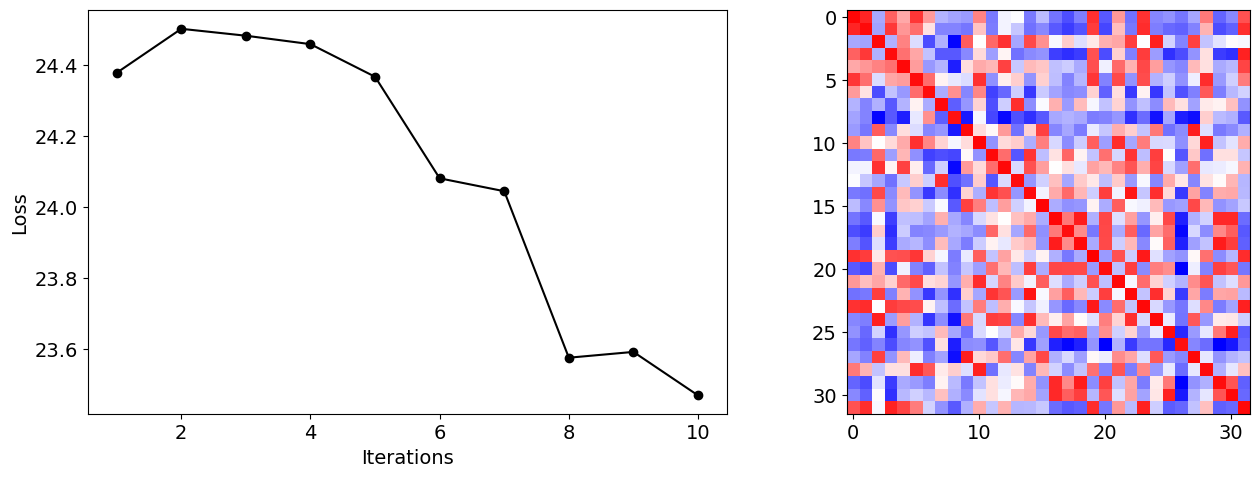

In [11]:
plot_data = cb_qkt.get_callback_data()
K = optimized_kernel.evaluate(img_batch)

vis = QSVCVisualization(dataset)

vis.display_kernel_loss_and_matrix(plot_data, K)
# vis.display_dicision_border(img_batch, label_batch, qsvc)